In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import nltk.corpus
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import saved_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.math import reduce_mean

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\opata\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df = df.drop(['article_link'], axis = 1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
sarcastic = df['is_sarcastic'].value_counts()[1]
non_sarcastic = df['is_sarcastic'].value_counts()[0]
print('Sarcastic: ', sarcastic)
print('Non Sarcastic: ', non_sarcastic)
print('Sarcastic: ', (sarcastic)/(sarcastic + non_sarcastic)*100)
print('Non Sarcastic: ', (non_sarcastic)/(sarcastic + non_sarcastic)*100)

Sarcastic:  11724
Non Sarcastic:  14985
Sarcastic:  43.89531618555543
Non Sarcastic:  56.10468381444457


C:\Users\opata\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

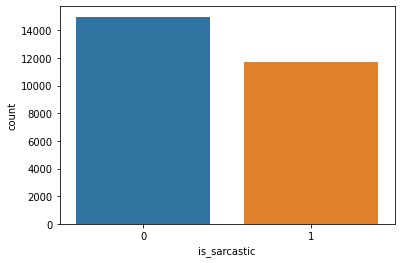

In [5]:
sns.countplot(df['is_sarcastic'])

In [7]:

len_sentence = 0
for i in range(df.shape[0]):
    temp = len(df['headline'][i].split(' '))
    if temp > len_sentence:
        len_sentence = temp
        no = i

print(df['headline'][no])

elmore leonard, modern prose master, noted for his terse prose style and for writing about things perfectly and succinctly with a remarkable economy of words, unfortunately and sadly expired this gloomy tuesday at the age of 87 years old


In [30]:
def f_word_cloud(column):
    
    comment_words = ' '
    stopwords = set(nltk.corpus.stopwords.words('english'))

    # iterate through the csv file 
    for val in column: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(comment_words) 
    
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis('off')
    plt.savefig(f'wordcloud.png', dpi=300)
    plt.show()
    
    return wordcloud

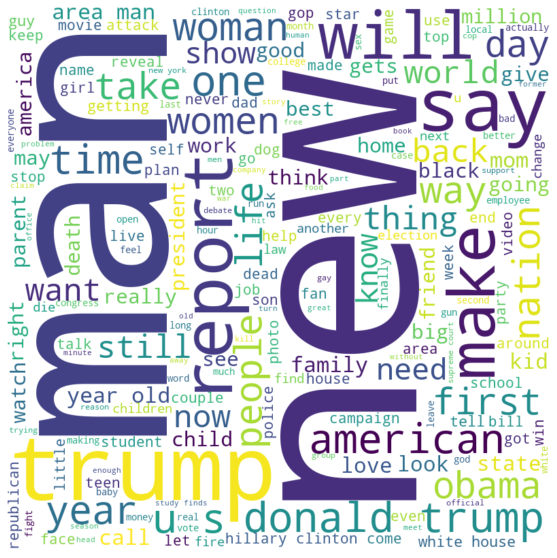

In [31]:
f_word_cloud(df['headline'])

In [84]:
def clean_headline(sent):
    sent = re.sub(r'[^a-zA-Z0-9_\s]+','',sent)
    return sent

In [85]:
df['clean_headline'] = df['headline'].apply(clean_headline)

for i in range(3):
    print('CLEAN',df['clean_headline'][i])
    print('ORIGINAL',df['headline'][i])
    print('\n')

CLEAN former versace store clerk sues over secret black code for minority shoppers
ORIGINAL former versace store clerk sues over secret 'black code' for minority shoppers


CLEAN the roseanne revival catches up to our thorny political mood for better and worse
ORIGINAL the 'roseanne' revival catches up to our thorny political mood, for better and worse


CLEAN mom starting to fear sons web series closest thing she will have to grandchild
ORIGINAL mom starting to fear son's web series closest thing she will have to grandchild




In [110]:
#Param 
max_length_of_headline = 50
num_words = 10000
Embedding_dimension = 50
lstm_out = 50

In [88]:
# Creating Embedding Matrix 
Emb_matrix = np.zeros((vocab_length+1,Embedding_dimension))

for word, index in words_to_index.items():
    embedding_vector = word_to_glove_map.get(word)
    if embedding_vector is not None:
        Emb_matrix[index, :] = embedding_vector

In [89]:
#train test split
# Features
X = df['clean_headline'].values

# labels
Y = df['is_sarcastic'].values
Y = to_categorical(Y,num_classes=2)

x_train,x_test,y_train,y_test= train_test_split(X,Y, test_size=0.3, random_state=123, stratify = Y)

In [90]:
# Tokenizing the text
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)

filename = 'tokenizer.pickle'
pickle.dump(tokenizer, open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
words_to_index = tokenizer.word_index
vocab_length = len(words_to_index)
print(len(words_to_index))

23738


In [92]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [93]:
word_to_glove_map = read_glove_vector('glove.6B.50d.txt')

In [94]:
# Creating Embedding Matrix 
Emb_matrix = np.zeros((vocab_length+1,Embedding_dimension))

for word, index in words_to_index.items():
    embedding_vector = word_to_glove_map.get(word)
    if embedding_vector is not None:
        Emb_matrix[index, :] = embedding_vector

In [95]:
Emb_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.68047 , -0.039263,  0.30186 , ..., -0.073297, -0.064699,
        -0.26044 ],
       [ 0.70853 ,  0.57088 , -0.4716  , ..., -0.22562 , -0.093918,
        -0.80375 ],
       ...,
       [-0.60353 , -0.35211 , -1.4623  , ...,  0.42397 ,  0.68375 ,
        -0.15564 ],
       [ 0.1884  , -0.81788 ,  0.82522 , ...,  0.027793,  0.024348,
         0.14737 ],
       [ 0.63914 ,  0.59262 ,  0.03767 , ..., -0.23276 ,  1.1301  ,
        -1.1121  ]])

In [96]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [97]:
x_train = pad_sequences(x_train,maxlen=50,padding='post',value=0)
x_test = pad_sequences(x_test,maxlen=50,padding='post',value=0)

In [125]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,Bidirectional,Input

Input = Input(shape = (50,))
embeding = Embedding(vocab_length+1,max_length_of_headline,weights = [Emb_matrix],trainable = True,embeddings_initializer='uniform')(Input)
dropout = Dropout(0.2)(embeding)
lstm = Bidirectional(LSTM(lstm_out, recurrent_dropout = 0.2))(dropout)
dense = Dense(10, activation = 'relu')(lstm)
output = Dense(2, activation = 'softmax')(dense)

model = Model(inputs = Input, outputs = output)

In [126]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 50, 50)            1186950   
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 2)                 22        
                                                           

In [139]:
# Optimizer
Optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4,beta_1 = 0.99,decay = 1e-5)

# Compile Model
model.compile(loss = 'categorical_crossentropy', optimizer=Optimizer,metrics = ['accuracy'])

In [144]:
#Callbacks

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,min_delta = 0.01)

ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint("Sarc_model-{val_loss:.2f}.h5",monitor='loss',save_best_only= True,save_weights_only=True)

reduceLoss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=2, min_lr=0.00001)

In [154]:
model.fit(x_train, y_train, epochs = 15 , batch_size= 32,  validation_data=(x_test,y_test),callbacks = [EarlyStopping,reduceLoss, ModelCheckpoint])

Epoch 1/15
585/585 [==============================] - 19s 32ms/step - loss: 0.3241 - accuracy: 0.8603 - val_loss: 0.3355 - val_accuracy: 0.8562 - lr: 1.0000e-05
Epoch 2/15
585/585 [==============================] - 19s 32ms/step - loss: 0.3214 - accuracy: 0.8619 - val_loss: 0.3414 - val_accuracy: 0.8522 - lr: 1.0000e-05
Epoch 3/15
585/585 [==============================] - 19s 32ms/step - loss: 0.3187 - accuracy: 0.8618 - val_loss: 0.3383 - val_accuracy: 0.8550 - lr: 1.0000e-05
Epoch 4/15
585/585 [==============================] - 19s 32ms/step - loss: 0.3219 - accuracy: 0.8589 - val_loss: 0.3394 - val_accuracy: 0.8536 - lr: 1.0000e-05
Epoch 5/15
585/585 [==============================] - 19s 32ms/step - loss: 0.3209 - accuracy: 0.8624 - val_loss: 0.3390 - val_accuracy: 0.8536 - lr: 1.0000e-05


In [149]:
F_model = Model(inputs = Input,outputs =output)
F_model.load_weights('Sarc_model-0.34.h5')
F_model.compile(loss = 'categorical_crossentropy', optimizer = Optimizer, metrics=['accuracy'])

In [164]:
loss,accuracy = F_model.evaluate(x_test,y_test, batch_size = 32)

print("Test data loss: %.2f"%(loss))
print("Test data accuracy: %.2f"%(accuracy))

251/251 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8536
Test data loss: 0.34
Test data accuracy: 0.85


In [170]:
i = 99

test_sent = df['headline'][i]
print('Test_sent:', test_sent)

#converting to sequence
test_data = tokenizer.texts_to_sequences([test_sent])
test_data = pad_sequences(test_data, maxlen = 50, padding = 'post', value=0)

result = F_model.predict(test_data)

if np.argmax(result) == 1:
    print('Sentence is Sarcastic')
else:
    print('Sentence is not Sarcastic')
    
if df['is_sarcastic'][i] == 1:
    print('Truth: Sentence is Sarcastic')
else:
    print('Truth: Sentence is not Sarcastic')
    
if np.argmax(result) == df['is_sarcastic'][i]:
    print('It works!!!!!')
else:
    print("It doesn't work :-(")

Test_sent: what it's like to lose everything in a flood
1/1 [==============================] - 0s 25ms/step
Sentence is not Sarcastic
Truth: Sentence is not Sarcastic
It works!!!!!


In [176]:
from tensorflow.keras.models import save_model

In [177]:
save_model(model,'model')

INFO:tensorflow:Assets written to: model\assets
